# import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.executable

'/home/lcances/.miniconda3/envs/dct/bin/python'

In [3]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time

import numpy
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.cuda.amp import autocast

from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

In [4]:
from SSL.util.model_loader import load_model
from SSL.util.loaders import load_dataset, load_optimizer, load_callbacks, load_preprocesser
from SSL.util.checkpoint import CheckPoint, mSummaryWriter
from SSL.util.utils import reset_seed, get_datetime, track_maximum

from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage

# Arguments

In [5]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../datasets", type=str)
parser.add_argument("-D", "--dataset", default="esc10", type=str, help="available [ubs8k | cifar10]")

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("-m", "--model", default="cnn03", type=str)
group_t.add_argument("--supervised_ratio", default=1.0, type=float)
group_t.add_argument("--batch_size", default=64, type=int)
group_t.add_argument("--nb_epoch", default=100, type=int)
group_t.add_argument("--learning_rate", default=0.003, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--preload_dataset", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)

group_m = parser.add_argument_group("Model parameters")
group_m.add_argument("--num_classes", default=10, type=int)

group_u = parser.add_argument_group("Datasets parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[5], type=int)

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../tensorboard/", type=str)
group_l.add_argument("--checkpoint_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args = parser.parse_args("")

tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

In [6]:
args

Namespace(batch_size=64, checkpoint_path='supervised', checkpoint_root='../model_save/', dataset='esc10', dataset_root='../datasets', from_config='', learning_rate=0.003, model='cnn03', nb_epoch=100, num_classes=10, preload_dataset=False, resume=False, seed=1234, supervised_ratio=1.0, tensorboard_path='supervised', tensorboard_root='../tensorboard/', tensorboard_sufix='', train_folds=[1, 2, 3, 4], val_folds=[5])

# initialisation

In [7]:
reset_seed(args.seed)


# Prepare the dataset

In [8]:
args.dataset_root

'../datasets'

In [9]:
train_transform, val_transform = load_preprocesser(args.dataset, "supervised")

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [10]:
manager, train_loader, val_loader = load_dataset(
    args.dataset,
    "supervised",
    
    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,

    train_transform=train_transform,
    val_transform=val_transform,
    
    num_workers=0,
    pin_memory=True,

    verbose = 2
)

Dataset already downloaded and verified.
Dataset already downloaded and verified.


In [11]:
input_shape = tuple(train_loader.dataset[0][0].shape)

# Prep model

In [37]:
import torch
from torch import Tensor
from torch.autograd import Variable
from torch.nn import Parameter
from augmentation_utils.spec_augmentations import Noise


class NoiseLayer(nn.Module):
    def __init__(self, ratio: float = 1.0, init_snr: float = 20):
        super().__init__()
        self.register_parameter(name='snr', param=Parameter(torch.tensor(20.0)))
        self.dropout = nn.Dropout(1.0 - ratio)
        
    def forward(self, x):
        if self.dropout.p == 1.0:
            return x

        # Create the noise
        noise = torch.randn(size=x.size()).cuda()
        noise *= self.snr

        # Create the application mask
        mask = torch.ones(x.size()[0])
        mask = self.dropout(mask)
        mask = torch.clamp(mask, 0, 1)
        mask = mask.cuda()

        for i, m in enumerate(mask):
            noise[i] = noise[i] * m

        y = x + noise
        y = torch.clamp(y, x.min(), x.max())

        return y

In [13]:
noisier = NoiseLayer()
noisier = noisier.cuda()

In [14]:
for p in noisier.parameters():
    print(p)

Parameter containing:
tensor(20., device='cuda:0', requires_grad=True)


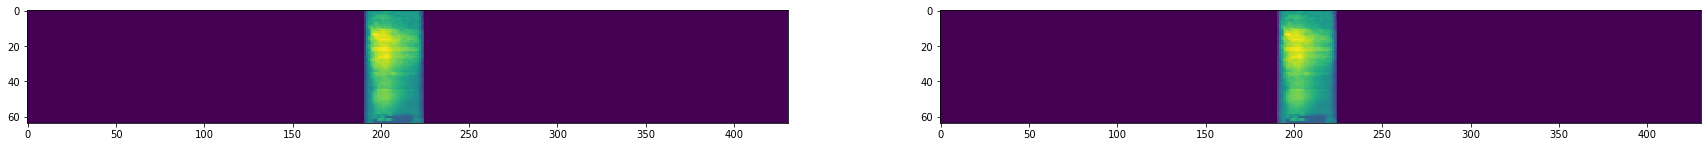

In [15]:
import matplotlib.pyplot as plt
x, y = train_loader.dataset[0]
x = x.unsqueeze(0)

plt.figure(0, figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.imshow(x.detach().numpy()[0])

plt.subplot(1, 2, 2)
plt.imshow(noisier(x.cuda()).detach().cpu().numpy()[0])

In [16]:
torch.cuda.empty_cache()

model_func = load_model(args.dataset, args.model)
# model_func = get_model_from_name("esc_wideresnet28_8")
model = model_func(input_shape=input_shape, num_classes = args.num_classes)
model = model.cuda()


1872 10


In [17]:
from torchsummary import summary

s = summary(model, input_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 24, 64, 431]             240
         MaxPool2d-2          [-1, 24, 16, 215]               0
       BatchNorm2d-3          [-1, 24, 16, 215]              48
             ReLU6-4          [-1, 24, 16, 215]               0
            Conv2d-5          [-1, 48, 16, 215]          10,416
         MaxPool2d-6           [-1, 48, 4, 107]               0
       BatchNorm2d-7           [-1, 48, 4, 107]              96
             ReLU6-8           [-1, 48, 4, 107]               0
            Conv2d-9           [-1, 72, 4, 107]          31,176
        MaxPool2d-10            [-1, 72, 2, 53]               0
      BatchNorm2d-11            [-1, 72, 2, 53]             144
            ReLU6-12            [-1, 72, 2, 53]               0
           Conv2d-13            [-1, 72, 2, 53]          46,728
        MaxPool2d-14            [-1, 72

# training parameters

In [18]:
# tensorboard
title_element = (args.model, args.supervised_ratio, get_datetime(), model_func.__name__, args.supervised_ratio)
tensorboard_title = "%s/%sS/%s_%s_%.1fS" % title_element

title_element = (model_func.__name__, args.supervised_ratio)
checkpoint_title = "%s_%.1fS" % title_element

tensorboard = mSummaryWriter(log_dir="%s/%s" % (tensorboard_path, tensorboard_title), comment=model_func.__name__)
print(os.path.join(tensorboard_path, tensorboard_title))

# losses
loss_ce = nn.CrossEntropyLoss(reduction="mean")

../tensorboard/esc10/supervised/cnn03/1.0S/2020-11-09_11:14:58_cnn03_1.0S


In [19]:
tensorboard_params = {}
for key, value in args.__dict__.items():
    tensorboard_params[key] = str(value)

In [20]:
tensorboard.add_hparams(tensorboard_params, {})

## optimizer & callbacks

In [21]:
optimizer = load_optimizer(args.dataset, "supervised", model=model, learning_rate=args.learning_rate)
callbacks = load_callbacks(args.dataset, "supervised", optimizer=optimizer, nb_epoch=args.nb_epoch)

In [22]:
# Checkpoint
checkpoint = CheckPoint(model, optimizer, mode="max", name="%s/%s.torch" % (checkpoint_path, checkpoint_title))

# Metrics
fscore_fn = FScore()
acc_fn = CategoricalAccuracy()
avg = ContinueAverage()

maximum_tracker = track_maximum()

reset_metrics = lambda : [m.reset() for m in [fscore_fn, acc_fn, avg]]

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Can resume previous training

In [23]:
if args.resume:
    checkpoint.load_last()

In [24]:
args.resume

False

## training function

In [25]:
UNDERLINE_SEQ = "\033[1;4m"
RESET_SEQ = "\033[0m"


header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<8.8} {:<6.6} - {:<9.9} {:<12.12}| {:<9.9}- {:<6.6}"
value_form  = "{:<8.8} {:<6} - {:<6} - {:<8.8} {:<6.4f} - {:<9.9} {:<10.4f}| {:<9.4f}- {:<6.4f}"

header = header_form.format(
    ".               ", "Epoch", "%", "Losses:", "ce", "metrics: ", "acc", "F1 ","Time"
)


train_form = value_form
val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

print(header)

.        Epoch  - %      - Losses:  ce     - metrics:  acc         | F1       - Time  


In [26]:
noisier = NoiseLayer(ratio=0.0, init_snr=6)

def train(epoch):
    start_time = time.time()
    print("")

    reset_metrics()
    model.train()

    for i, (X, y) in enumerate(train_loader):        
        X = X.cuda()
        y = y.cuda()

        X = noisier(X)
        
        logits_X = model(X)        
        # logits_X_ = model(X_)

        loss = loss_ce(logits_X, y)
        # loss_aug = aug_loss(logits_X, logits_X_)

        optimizer.zero_grad()
        # aug_opti.zero_grad()
        
        loss.backward()
        # loss_aug.backward()

        optimizer.step()
        # aug_opti.step()

        with torch.set_grad_enabled(False):
            pred = torch.softmax(logits_X, dim=1)
            pred_arg = torch.argmax(logits_X, dim=1)
            y_one_hot = F.one_hot(y, num_classes=args.num_classes)

            acc = acc_fn(pred_arg, y).mean
            fscore = fscore_fn(pred, y_one_hot).mean
            avg_ce = avg(loss.item()).mean

            # logs
            print(train_form.format(
                "Training: ",
                epoch + 1,
                int(100 * (i + 1) / len(train_loader)),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("train/Lce", avg_ce, epoch)
    tensorboard.add_scalar("train/f1", fscore, epoch)
    tensorboard.add_scalar("train/acc", acc, epoch)

In [27]:
def val(epoch):
    start_time = time.time()
    print("")
    reset_metrics()
    model.eval()

    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(val_loader):
            X = X.cuda()
            y = y.cuda()

            logits = model(X)
            loss = loss_ce(logits, y)

            # metrics
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=args.num_classes)

            acc = acc_fn(pred_arg, y).mean
            fscore = fscore_fn(pred, y_one_hot).mean
            avg_ce = avg(loss.item()).mean

            # logs
            print(val_form.format(
                "Validation: ",
                epoch + 1,
                int(100 * (i + 1) / len(val_loader)),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("val/Lce", avg_ce, epoch)
    tensorboard.add_scalar("val/f1", fscore, epoch)
    tensorboard.add_scalar("val/acc", acc, epoch)
    
    tensorboard.add_scalar("hyperparameters/learning_rate", get_lr(optimizer), epoch)
    
    tensorboard.add_scalar("max/acc", maximum_tracker("acc", acc), epoch )
    tensorboard.add_scalar("max/f1", maximum_tracker("f1", fscore), epoch )

    checkpoint.step(acc)
    for c in callbacks:
        c.step()


In [28]:
print(header)

start_epoch = checkpoint.epoch_counter
end_epoch = args.nb_epoch

args.nb_epoch = 100
for e in range(start_epoch, args.nb_epoch):
    train(e)
    val(e)
    
    tensorboard.flush()

.        Epoch  - %      - Losses:  ce     - metrics:  acc         | F1       - Time  

Training 1      - 100    -          2.0345 -           0.2656    | 0.0965   - 2.5676
Validati 1      - 100    -          2.5470 -           0.2188    | 0.3068   - 0.4729
Training 2      - 100    -          1.2253 -           0.5219    | 0.3648   - 0.4483
Validati 2      - 100    -          3.4100 -           0.2969    | 0.3063   - 0.0172
Training 3      - 100    -          0.9396 -           0.6406    | 0.5896   - 0.4315
Validati 3      - 100    -          3.9036 -           0.3438    | 0.3872   - 0.0182
Training 4      - 100    -          0.6590 -           0.7656    | 0.7444   - 0.4383
Validati 4      - 100    -          4.0962 -           0.3984    | 0.3919   - 0.0156
Training 5      - 100    -          0.4959 -           0.8250    | 0.8114   - 0.4311
Validati 5      - 100    -          2.1161 -           0.5938    | 0.6129   - 0.0158
Training 6      - 100    -          0.3715 -           0.8813 

# Optimize augmentation function

In [29]:
# monitor noise snr
def get_snr():
    for p in noisier.parameters():
        return p

In [38]:
noisier = NoiseLayer(ratio=1.0, init_snr=20)


aug_loss = nn.MSELoss(reduction="mean")
aug_opti = torch.optim.Adam(noisier.parameters(), lr=0.05)

In [39]:
header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<8.8} {:<6.6} {:<6.6} - {:<6.6}"
value_form  = "{:<8.8} {:<6} - {:<6} - {:<8.8} {:<6.4f} {:<6.4f} - {:<6.4f}"
header = header_form.format(".               ", "Epoch", "%", "Losses:", "ce", "snr", "Time")

def aug_train(epoch):
    start_time = time.time()
    print("")

    reset_metrics()
    model.train()
    noisier.train()

    for i, (X, y) in enumerate(train_loader):        
        X = X.cuda()
        y = y.cuda()

        X_ = noisier(X)
        
        logits_X = model(X)        
        logits_X_ = model(X_)

        loss_aug = aug_loss(logits_X, logits_X_)
        
        aug_opti.zero_grad()
        loss_aug.backward()
        aug_opti.step()

        with torch.set_grad_enabled(False):
            avg_ce = avg(loss_aug.item()).mean

            # logs
            print(value_form.format(
                "Augmentation: ",
                epoch + 1,
                int(100 * (i + 1) / len(train_loader)),
                "", avg_ce, get_snr().item(),
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("train/aug_ce", avg_ce, epoch)

In [42]:
print(header)
for e in range(100):
    aug_train(e)

.        Epoch  - %      - Losses:  ce     snr    - Time  

Augmenta 1      - 100    -          8.0982 3.4950 - 0.5970
Augmenta 2      - 100    -          9.0293 3.4296 - 0.5533
Augmenta 3      - 100    -          9.1993 3.3625 - 0.5516
Augmenta 4      - 100    -          8.6274 3.2979 - 0.5523
Augmenta 5      - 100    -          8.7221 3.2375 - 0.5355
Augmenta 6      - 100    -          8.1128 3.1826 - 0.5438
Augmenta 7      - 100    -          8.9913 3.1321 - 0.5375
Augmenta 8      - 100    -          8.2906 3.0815 - 0.5343
Augmenta 9      - 100    -          8.6872 3.0272 - 0.5409
Augmenta 10     - 100    -          8.7007 2.9723 - 0.5430
Augmenta 11     - 100    -          9.2414 2.9202 - 0.5488
Augmenta 12     - 100    -          8.0495 2.8678 - 0.5296
Augmenta 13     - 100    -          8.2616 2.8129 - 0.5371
Augmenta 14     - 100    -          8.5471 2.7626 - 0.5386
Augmenta 15     - 100    -          8.0313 2.7096 - 0.5383
Augmenta 16     - 100    -          8.5107 2.6599 - 0.5

In [43]:
for p in noisier.parameters():
    print(p)

Parameter containing:
tensor(0.8853, requires_grad=True)


## display

In [46]:
import matplotlib.pyplot as plt

x = list(range(checkpoint.epoch_counter))
sm = lambda y, w: np.convolve(y, np.ones(w)/w, mode='same')
pp = lambda k: plt.plot(x, tensorboard.history[k], label=f"{k} = {max(tensorboard.history[k])}")
spp = lambda k: plt.plot(x, sm(tensorboard.history[k], 5), label=f"{k} = {max(tensorboard.history[k])}")


plt.figure(0, figsize=(30, 14))
plt.subplot(2, 3, 1)
pp("val/acc")
pp("val/f1")
plt.legend()

plt.subplot(2, 3, 2)
pp("max/acc")
pp("max/f1")
plt.legend()

plt.subplot(2, 3, 3)
# pp("train/Lce")
pp("train/aug_ce")
plt.legend()

# plt.subplot(2, 3, 4)
# pp("train/snr")
# plt.legend()

plt.show()

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

In [47]:
print(len(x))

100


# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪